In [1]:
# import the necessary packages
from imutils.object_detection import non_max_suppression
from matplotlib import pyplot as plt
import numpy as np
import argparse
import time
import cv2

In [2]:
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-i", "--image", type=str,
	help="path to input image", default='images/page3-120s.png')
ap.add_argument("-east", "--east", type=str,
	help="path to input EAST text detector", default='frozen_east_text_detection.pb')
ap.add_argument("-c", "--min-confidence", type=float, default=0.8,
	help="minimum probability required to inspect a region")
ap.add_argument("-w", "--width", type=int, default=1600,
	help="resized image width (should be multiple of 32)")
ap.add_argument("-e", "--height", type=int, default=1600,
	help="resized image height (should be multiple of 32)")
ap
args, unknown = ap.parse_known_args()
#args = vars(ap.parse_args())
args = vars(args)
args

{'image': 'images/page3-120s.png',
 'east': 'frozen_east_text_detection.pb',
 'min_confidence': 0.8,
 'width': 1600,
 'height': 1600}

In [3]:
# load the input image and grab the image dimensions
image = cv2.imread(args["image"])
orig = image.copy()
(H, W) = image.shape[:2]

(H, W)

(2200, 1700)

In [4]:
# set the new width and height and then determine the ratio in change
# for both the width and height
(newW, newH) = (args["width"], args["height"])
rW = W / float(newW)
rH = H / float(newH)

In [5]:
# resize the image and grab the new image dimensions
image = cv2.resize(image, (newW, newH))
(H, W) = image.shape[:2]
(H, W)

(1600, 1600)

In [6]:
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

In [7]:
# load the pre-trained EAST text detector
print("[INFO] loading EAST text detector...")
net = cv2.dnn.readNet(args["east"])

[INFO] loading EAST text detector...


In [8]:
# construct a blob from the image and then perform a forward pass of
# the model to obtain the two output layer sets
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
	(123.68, 116.78, 103.94), swapRB=True, crop=False)
start = time.time()
net.setInput(blob)
(scores, geometry) = net.forward(layerNames)
end = time.time()
# show timing information on text prediction
print("[INFO] text detection took {:.6f} seconds".format(end - start))
(scores,geometry)

[INFO] text detection took 25.759748 seconds


(array([[[[2.8448309e-07, 1.3735039e-06, 9.3358716e-07, ...,
           1.2348416e-06, 2.2094670e-07, 1.9597428e-06],
          [1.7966454e-06, 1.1973417e-06, 9.1207193e-07, ...,
           1.4750954e-06, 1.2054358e-07, 1.3632207e-06],
          [1.5951438e-06, 8.9822879e-07, 8.1203336e-07, ...,
           9.9591205e-07, 4.8218240e-08, 1.9974977e-06],
          ...,
          [3.2209896e-06, 5.2078207e-07, 5.2869927e-07, ...,
           5.4060303e-07, 8.7019004e-08, 3.7295333e-06],
          [1.1092066e-06, 7.8786451e-07, 7.4858690e-07, ...,
           1.6275005e-06, 9.6107431e-07, 4.5167490e-06],
          [1.4297525e-06, 1.8047700e-07, 1.5952533e-07, ...,
           3.0637167e-07, 8.9106564e-08, 2.6818489e-07]]]], dtype=float32),
 array([[[[ 1.59544113e+02,  1.26238297e+02,  1.31515198e+02, ...,
            1.32120239e+02,  1.23778465e+02,  1.57003021e+02],
          [ 1.28443680e+02,  7.16234283e+01,  7.46543732e+01, ...,
            7.65483322e+01,  7.52470551e+01,  1.13497871e+02]

In [9]:
# grab the number of rows and columns from the scores volume, then
# initialize our set of bounding box rectangles and corresponding
# confidence scores
(numRows, numCols) = scores.shape[2:4]
rects = []
confidences = []

In [10]:
# loop over the number of rows
for y in range(0, numRows):
	# extract the scores (probabilities), followed by the geometrical
	# data used to derive potential bounding box coordinates that
	# surround text
	scoresData = scores[0, 0, y]
	xData0 = geometry[0, 0, y]
	xData1 = geometry[0, 1, y]
	xData2 = geometry[0, 2, y]
	xData3 = geometry[0, 3, y]
	anglesData = geometry[0, 4, y]

	# loop over the number of columns
	for x in range(0, numCols):
		# if our score does not have sufficient probability, ignore it
		if scoresData[x] < args["min_confidence"]:
			continue

		# compute the offset factor as our resulting feature maps will
		# be 4x smaller than the input image
		(offsetX, offsetY) = (x * 4.0, y * 4.0)

		# extract the rotation angle for the prediction and then
		# compute the sin and cosine
		angle = anglesData[x]
		cos = np.cos(angle)
		sin = np.sin(angle)

		# use the geometry volume to derive the width and height of
		# the bounding box
		h = xData0[x] + xData2[x]
		w = xData1[x] + xData3[x]
        

		# A more accurate bounding box for rotated text
		offsetX = offsetX + cos * xData1[x] + sin * xData2[x]
		offsetY = offsetY - sin * xData1[x] + cos * xData2[x]
		# calculate the UL and LR corners of the bounding rectangle
		p1x = -cos * w + offsetX
		p1y = -cos * h + offsetY
		p3x = -sin * h + offsetX
		p3y = sin * w + offsetY
		# add the bounding box coordinates
		rects.append((p1x, p1y, p3x, p3y))
		confidences.append(scoresData[x])

In [11]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
boxes = non_max_suppression(np.array(rects), probs=confidences)

In [12]:
# loop over the bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the bounding box coordinates based on the respective
	# ratios
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	# draw the bounding box on the image
	cv2.rectangle(orig, (startX, startY), (endX, endY), (0, 255, 0), 2)

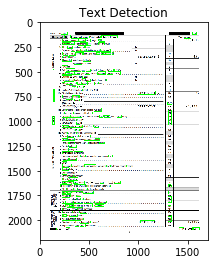

In [13]:
# show the output image
#cv2.imshow("Text Detection", orig)
#cv2.waitKey(0)
#Matplot lib expects img in RGB format but OpenCV provides it in BGR.
gray = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
cv2.imwrite('images/output/markup.jpg', orig)
plt.imshow(gray)
plt.title('Text Detection')
plt.show()